<a href="https://colab.research.google.com/github/RahulReadd/Computer_Vision_Projects-/blob/main/Panorama/InterIITPS_Chandrayaan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)
import warnings 
import sys
warnings.filterwarnings('ignore')

In [2]:
def feature_matching(img1, img2, savefig=False):
    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches2to1 = flann.knnMatch(des2,des1,k=2)

    matchesMask_ratio = [[0,0] for i in range(len(matches2to1))]
    match_dict = {}
    for i,(m,n) in enumerate(matches2to1):
        if m.distance < 0.7*n.distance:
            matchesMask_ratio[i]=[1,0]
            match_dict[m.trainIdx] = m.queryIdx

    good = []
    recip_matches = flann.knnMatch(des1,des2,k=2)
    matchesMask_ratio_recip = [[0,0] for i in range(len(recip_matches))]

    for i,(m,n) in enumerate(recip_matches):
        if m.distance < 0.7*n.distance: # ratio
            if m.queryIdx in match_dict and match_dict[m.queryIdx] == m.trainIdx: #reciprocal
                good.append(m)
                matchesMask_ratio_recip[i]=[1,0]



    if savefig:
        draw_params = dict(matchColor = (0,255,0),
                           singlePointColor = (255,0,0),
                           matchesMask = matchesMask_ratio_recip,
                           flags = 0)
        img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,recip_matches,None,**draw_params)

        plt.figure(),plt.xticks([]),plt.yticks([])
        plt.imshow(img3,)
        plt.savefig("feature_matching.png",bbox_inches='tight')

    return ([ kp1[m.queryIdx].pt for m in good ],[ kp2[m.trainIdx].pt for m in good ])


In [3]:
def Laplacian_Pyramid_Blending_with_mask(A, B, m, num_levels = 6):
    # assume mask is float32 [0,1]

    # generate Gaussian pyramid for A,B and mask
    GA = A.copy()
    GB = B.copy()
    GM = m.copy()
    gpA = [GA]
    gpB = [GB]
    gpM = [GM]
    for i in range(num_levels):
        GA = cv2.pyrDown(GA)
        GB = cv2.pyrDown(GB)
        GM = cv2.pyrDown(GM)
        gpA.append(np.float32(GA))
        gpB.append(np.float32(GB))
        gpM.append(np.float32(GM))

    # generate Laplacian Pyramids for A,B and masks
    lpA  = [gpA[num_levels-1]] # the bottom of the Lap-pyr holds the last (smallest) Gauss level
    lpB  = [gpB[num_levels-1]]
    gpMr = [gpM[num_levels-1]]
    for i in range(num_levels-1,0,-1):
        # Laplacian: subtarct upscaled version of lower level from current level
        # to get the high frequencies
        LA = np.subtract(gpA[i-1], cv2.pyrUp(gpA[i]))
        LB = np.subtract(gpB[i-1], cv2.pyrUp(gpB[i]))
        lpA.append(LA)
        lpB.append(LB)
        gpMr.append(gpM[i-1]) # also reverse the masks

    # Now blend images according to mask in each level
    LS = []
    for la,lb,gm in zip(lpA,lpB,gpMr):
        ls = la * gm + lb * (1.0 - gm)
        LS.append(ls)

    # now reconstruct
    ls_ = LS[0]
    for i in range(1,num_levels):
        ls_ = cv2.pyrUp(ls_)
        ls_ = cv2.add(ls_, LS[i])

    return ls_

In [4]:
def getTransform(src, dst, method='affine'):
    pts1,pts2 = feature_matching(src,dst)

    src_pts = np.float32(pts1).reshape(-1,1,2)
    dst_pts = np.float32(pts2).reshape(-1,1,2)

    if method == 'affine':
        M, mask = cv2.estimateAffine2D(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=5.0)
        # M = np.append(M, [[0,0,1]], axis=0)

    if method == 'homography':
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    matchesMask = mask.ravel().tolist()

    return (M, pts1, pts2, mask)
   

In [5]:
def Perspective_warping(img1, img2, img3):

  # Write your codes here
  im1 = img1
  im2 = img2
  im3 = img3

  im1 = cv2.copyMakeBorder(im1,200,200,500,500, cv2.BORDER_CONSTANT)        
  (M, pts1, pts2, mask) = getTransform(im2, im1, 'homography')
  out = cv2.warpPerspective(im2, M, (im1.shape[1],im1.shape[0]), dst=im1.copy(), borderMode=cv2.BORDER_TRANSPARENT)


  (M, pts1, pts2, mask) = getTransform(im3, out, 'homography')
  output_image = cv2.warpPerspective(im3, M, (out.shape[1],out.shape[0]), dst=out.copy(), borderMode=cv2.BORDER_TRANSPARENT)	
  plt.imshow(output_image)
  # Write out the result
  output_name = "output_homography.png"
  cv2.imwrite(output_name, output_image)

  return True

In [7]:
  input_image1 = cv2.imread("/content/1.jpeg")
  input_image2 = cv2.imread("/content/2.jpeg")
  input_image3 = cv2.imread("/content/3.jpeg") 

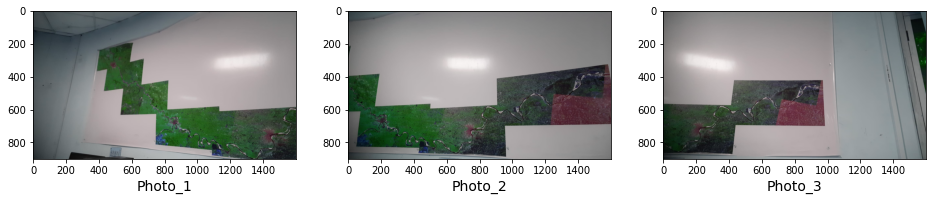

In [9]:
#Visualizing the images
def ImageShow(Photo_1, Photo_2, Photo_3):
  from matplotlib.colorbar import constrained_layout  
  #Ploting photos
  fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, constrained_layout = False,  figsize=(16,9))
  ax1.imshow(Photo_1, cmap = "gray")
  ax1.set_xlabel("Photo_1", fontsize = 14)

  ax2.imshow(Photo_2, cmap = "gray")
  ax2.set_xlabel("Photo_2", fontsize = 14)

  ax3.imshow(Photo_3, cmap = "gray")
  ax3.set_xlabel("Photo_3", fontsize = 14)

  plt.savefig("./_" + '.jpeg', bbox_inches = 'tight', dpi = 300, optimize = True, format = 'jpeg')

  plt.show()

ImageShow(input_image1, input_image2, input_image3)

True

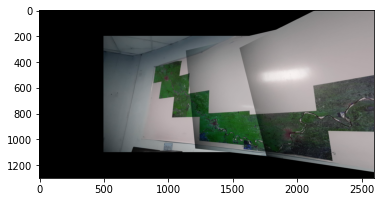

In [10]:
Perspective_warping(input_image1, input_image2, input_image3)